<a href="https://colab.research.google.com/github/adihatake/Improving-OCT-Interpretation-through-Retrieval-Guided-Diagnosis-and-LLM-Based-Reporting/blob/main/Indicium_ResNet50_Training_and_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README!
**Cells required to execute:**
1. Load the dependencies
2. Load datasets from dis
3. Preprocess the data
4. Define the model

**For Inference:**
A model must be trained or loaded locally from your disk. Once this has been done, execute the "inspect an example" cell

**For FAISS Retrieval**
A FAISS index must be created or loaded locally from your disk. Execute the "make a FAISS query" to make a retrieval.

---





# Load dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install -U datasets
! pip install faiss-cpu
! pip install langchain-community
! pip install -U langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datasets
import numpy as np
import random
import faiss
import os


from PIL import Image
from datasets import load_dataset, load_from_disk

from torch.utils.data import DataLoader
from torchvision import transforms


from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain.schema import Document
from langchain.chat_models import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.docstore import InMemoryDocstore


# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Load datasets from disk

In [ ]:
# Load datasets locally
raw_train_data = load_dataset("parquet", data_files="/content/drive/MyDrive/Indicium/OLIVES_train_seed42.parquet")['train']
raw_val_data = load_dataset("parquet", data_files="/content/drive/MyDrive/Indicium/OLIVES_val_seed42.parquet")['train']
raw_test_data = load_dataset("parquet", data_files="/content/drive/MyDrive/Indicium/OLIVES_test_seed42.parquet")['train']

In [ ]:
print(raw_train_data)
print(raw_val_data)
print(raw_test_data)

Dataset({
    features: ['Image', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face', 'Preretinal tissue/hemorrhage', 'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)', 'Disruption of RPE', 'PED (serous)', 'SHRM', 'Patient_ID', 'Disease Label', '__index_level_0__'],
    num_rows: 14247
})
Dataset({
    features: ['Image', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face', 'Preretinal tissue/hemorrhage', 'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)', 'Disruption of RPE', 'PED (serous)', 'SHRM', 'Patient_ID', 'Disease Label'],
    num_rows: 1654
})
Dataset({
    features: ['Image', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreo

In [ ]:
print(f"Train size: {len(raw_train_data)}")
print(f"Test size: {len(raw_test_data)}")
print(f"Validation size: {len(raw_val_data)}")

Train size: 14247
Test size: 1568
Validation size: 1654


In [ ]:
from collections import Counter

# Get frequency of disease labels in each class
train_label_counts = Counter(raw_train_data['Disease Label'])
print("\nTrain disease label counts:")
print(train_label_counts)

val_label_counts = Counter(raw_val_data['Disease Label'])
print("\nValidation disease label counts:")
print(val_label_counts)

test_label_counts = Counter(raw_test_data['Disease Label'])
print("\nTest disease label counts:")
print(test_label_counts)



Train disease label counts:
Counter({1.0: 7975, 0.0: 6272})

Validation disease label counts:
Counter({1.0: 968, 0.0: 686})

Test disease label counts:
Counter({0.0: 784, 1.0: 784})


# Preprocess the data
This includes converting the images to RGB and applying ResNet50's standard preprocessing and one-hot encoding the biomarkers.

In [ ]:
# Define biomarker fields
biomarker_fields = [
    "Atrophy / thinning of retinal layers",
    "Disruption of EZ",
    "DRIL",
    "IR hemorrhages",
    "IR HRF",
    "Partially attached vitreous face",
    "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage",
    "Vitreous debris",
    "VMT",
    "DRT/ME",
    "Fluid (IRF)",
    "Fluid (SRF)",
    "Disruption of RPE",
    "PED (serous)",
    "SHRM"
]

import io


# Define transforms for validation and test datasets
resnet_transform = transforms.Compose([
    transforms.Resize(256),                        # Resize shorter side to 256
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),                 # Converts to [C, H, W] in range [0, 1]
    transforms.Normalize(                  # Standard ImageNet normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



# Define transforms for the training data.
# Here we use the standard ResNet transform but apply random augmentations
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4),  # ±40% brightness and contrast
    transforms.RandomHorizontalFlip(p=0.5),                # 50% horizontal flip
    transforms.RandomRotation(degrees=8),                  # ±8° rotation
    transforms.RandomResizedCrop(224,                      # ResNet expects 224x224
                                 scale=(0.25, 1.0),
                                 ratio=(0.75, 1.33)),
    transforms.Grayscale(num_output_channels=3),           # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class RetinalDataset(torch.utils.data.Dataset):
    def __init__(self, data, biomarker_fields=None, transform=None):
        self.data = data
        self.biomarker_fields = biomarker_fields
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_bytes = item['Image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        if self.transform:
            img = self.transform(img)

        biomarkers = [item[field] for field in self.biomarker_fields]
        biomarkers = torch.tensor(biomarkers, dtype=torch.float32)


        return {
            'image pixel values': img,
            'biomarkers': biomarkers,
            'label': item['Disease Label'],
            'patient_id': item['Patient_ID']
        }



# Define the training and test torch Datasets
processed_train_data = RetinalDataset(
    data=raw_train_data,
    biomarker_fields=biomarker_fields,
    transform=train_transform
)


processed_val_data = RetinalDataset(
    data=raw_val_data,
    biomarker_fields=biomarker_fields,
    transform=resnet_transform
)


processed_test_data = RetinalDataset(
    data=raw_test_data,
    biomarker_fields=biomarker_fields,
    transform=resnet_transform
)


In [ ]:
import torch
import numpy as np
import random

# Define a manual seeding function to consistently shuffle the datasets
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42) # Set anual seed to 42 by convention


BATCH_SIZE = 32

# Wrap the datasets to a torch DataLoader to generate batches
# Here, arrange into batches, shuffle the dataset and use
# num_workers to maximize CPU cores for fetching.

train_dataloader = DataLoader(processed_train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4,
                              worker_init_fn=seed_worker,
                              generator=g)

validation_dataloader = DataLoader(processed_val_data,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=4,
                                   worker_init_fn=seed_worker,
                                   generator=g)

# Used for model testing
test_dataloader = DataLoader(processed_test_data, batch_size=1, shuffle=False)

# Define the model
Here, we just concatenate the features learned from the biomarker and disease heads and return them for FAISS


---



In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class OCT_net(nn.Module):
    def __init__(self, num_biomarkers=len(biomarker_fields), num_diseases=2):
        super().__init__()

        # Load pre-trained ResNet50 and replace FC with identity
        pre_trained_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        pre_trained_model.fc = nn.Identity()

        # Freeze all layers in the backbone
        for param in pre_trained_model.parameters():
            param.requires_grad = False

        self.backbone = pre_trained_model
        self.feature_dim = 2048  # Output of resnet50 with identity FC

        # Biomarker regression head
        self.biomarker_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_biomarkers)
        )

        # Disease classification head
        self.disease_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_diseases)
        )

    def forward(self, x, return_features=False, head=None):
        x = self.backbone(x)  # Shape: (B, 2048)

        biomarker_logits = self.biomarker_head(x)
        disease_logits = self.disease_head(x)

        if return_features:
            biomarker_feats = self.biomarker_head[:-1](x)
            disease_feats = self.disease_head[:-1](x)
            combined = torch.cat([biomarker_feats, disease_feats], dim=1)
            embedding = F.normalize(combined, dim=1, p=2)
            return biomarker_logits, disease_logits, embedding

        if head == 'biomarker':
            return biomarker_logits
        elif head == 'disease':
            return disease_logits

        return biomarker_logits, disease_logits


model = OCT_net()
#print(model)


# Train the model




In [ ]:
# Check if using GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = OCT_net().to(device)

Using device: cuda


In [ ]:
# For biomarkers (multi-label classification)
biomarker_loss_fn = nn.BCEWithLogitsLoss()

# For disease (multi-class classification)
disease_loss_fn = nn.CrossEntropyLoss()

# Use Adam as our optimizer
LEARNING_RATE = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import os
import torch
from tqdm import tqdm

# Define number of epochs and where to save model checkpoints
num_epochs = 10
date_entry = "Jun_23"
checkpoint_dir = f"/content/drive/MyDrive/Indicium/model_checkpoints/{date_entry}_augmentations_finetuning"
os.makedirs(checkpoint_dir, exist_ok=True)

# Define lists to save training and validation metrics.
train_losses = []
train_bio_losses = []        # biomarker loss for training
train_disease_losses = []    # disease loss for training
train_accuracies = []

val_losses = []
val_bio_losses = []          # biomarker loss for validation
val_disease_losses = []      # disease loss for validation
val_accuracies = []

# Describes the main training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Define empty variables to save metrics for later
    batch_train_losses = []
    batch_train_bio_losses = []
    batch_train_disease_losses = []
    correct_train = 0
    total_train = 0

    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # For each batch in the dataset
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):

        # Access the images, biomarkers and labels.
        # We convert these to the device we are using
        # For biomarkers, we convert to float and for disease labels we convert to float 64
        images = batch['image pixel values'].to(device)
        biomarkers = batch['biomarkers'].float().to(device)
        disease_labels = batch['label'].long().to(device)

        # Reset the gradients to zero from previous batch
        optimizer.zero_grad()

        # Get the raw scores/logits from the biomarker and disease heades
        biomarker_logits, disease_logits = model(images)

        # Compute the losses
        loss_bio = biomarker_loss_fn(biomarker_logits, biomarkers)
        loss_disease = disease_loss_fn(disease_logits, disease_labels)
        # Add the losses
        total_loss = loss_bio + loss_disease

        # Backpropagate the losses
        total_loss.backward()
        # Update the model's weights
        optimizer.step()

        # Save the total loss for this batch
        batch_train_losses.append(total_loss.item())
        batch_train_bio_losses.append(loss_bio.item())
        batch_train_disease_losses.append(loss_disease.item())

        # Get predicted class and determine if it is correct.
        # Add to the total train and correct train variables
        preds = disease_logits.argmax(dim=1)
        correct_train += (preds == disease_labels).sum().item()
        total_train += disease_labels.size(0)

    # Compute the average training loss and accuracies
    avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
    avg_train_bio_loss = sum(batch_train_bio_losses) / len(batch_train_bio_losses)
    avg_train_disease_loss = sum(batch_train_disease_losses) / len(batch_train_disease_losses)
    train_accuracy = correct_train / total_train

    # Save these metrics to plot later
    train_losses.append(avg_train_loss)
    train_bio_losses.append(avg_train_bio_loss)
    train_disease_losses.append(avg_train_disease_loss)
    train_accuracies.append(train_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f} (Bio: {avg_train_bio_loss:.4f}, Disease: {avg_train_disease_loss:.4f}), Train Accuracy: {train_accuracy:.4f}")

    # Validation loop
    model.eval() # Make sure the model is in evaluating mode
    batch_val_losses = []
    batch_val_bio_losses = []
    batch_val_disease_losses = []
    correct_val = 0
    total_val = 0

    # Tells model to compute no gradients when evaluating. Very similar to the training loop
    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Validating Epoch {epoch+1}"):
            images = batch['image pixel values'].to(device)
            biomarkers = batch['biomarkers'].float().to(device)
            disease_labels = batch['label'].long().to(device)

            biomarker_logits, disease_logits = model(images)

            loss_bio = biomarker_loss_fn(biomarker_logits, biomarkers)
            loss_disease = disease_loss_fn(disease_logits, disease_labels)
            total_loss = loss_bio + loss_disease

            batch_val_losses.append(total_loss.item())
            batch_val_bio_losses.append(loss_bio.item())
            batch_val_disease_losses.append(loss_disease.item())

            preds = disease_logits.argmax(dim=1)
            correct_val += (preds == disease_labels).sum().item()
            total_val += disease_labels.size(0)

    # Compute the validation metrics and save for plotting later
    avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
    avg_val_bio_loss = sum(batch_val_bio_losses) / len(batch_val_bio_losses)
    avg_val_disease_loss = sum(batch_val_disease_losses) / len(batch_val_disease_losses)
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_bio_losses.append(avg_val_bio_loss)
    val_disease_losses.append(avg_val_disease_loss)
    val_accuracies.append(val_accuracy)

    print(f"Val Loss: {avg_val_loss:.4f} (Bio: {avg_val_bio_loss:.4f}, Disease: {avg_val_disease_loss:.4f}), Val Accuracy: {val_accuracy:.4f}")

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")

    # Specify the epochs, the model's state dictionary (its gradients and weights)
    # and other relevant metadata to our pre-defined checkpoint directory
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),

        # Metadata
        'optimizer_name': type(optimizer).__name__,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': num_epochs,

        'train_losses': train_losses,
        'train_bio_losses': train_bio_losses,
        'train_disease_losses': train_disease_losses,

        'val_losses': val_losses,
        'val_bio_losses': val_bio_losses,
        'val_disease_losses': val_disease_losses,

        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }, checkpoint_path)



Epoch 1/10


Training Epoch 1: 100%|██████████| 446/446 [00:51<00:00,  8.72it/s]


Train Loss: 0.8050 (Bio: 0.5026, Disease: 0.3024), Train Accuracy: 0.8685


Validating Epoch 1: 100%|██████████| 52/52 [00:03<00:00, 16.72it/s]


Val Loss: 0.7378 (Bio: 0.4923, Disease: 0.2455), Val Accuracy: 0.8900

Epoch 2/10


Training Epoch 2: 100%|██████████| 446/446 [00:50<00:00,  8.78it/s]


Train Loss: 0.7516 (Bio: 0.4838, Disease: 0.2678), Train Accuracy: 0.8866


Validating Epoch 2: 100%|██████████| 52/52 [00:03<00:00, 16.65it/s]


Val Loss: 0.7372 (Bio: 0.4797, Disease: 0.2576), Val Accuracy: 0.8767

Epoch 3/10


Training Epoch 3: 100%|██████████| 446/446 [00:50<00:00,  8.76it/s]


Train Loss: 0.7062 (Bio: 0.4708, Disease: 0.2354), Train Accuracy: 0.9048


Validating Epoch 3: 100%|██████████| 52/52 [00:03<00:00, 16.72it/s]


Val Loss: 0.7201 (Bio: 0.4720, Disease: 0.2481), Val Accuracy: 0.8779

Epoch 4/10


Training Epoch 4: 100%|██████████| 446/446 [00:50<00:00,  8.76it/s]


Train Loss: 0.6626 (Bio: 0.4562, Disease: 0.2064), Train Accuracy: 0.9157


Validating Epoch 4: 100%|██████████| 52/52 [00:03<00:00, 16.70it/s]


Val Loss: 0.7774 (Bio: 0.4684, Disease: 0.3089), Val Accuracy: 0.8585

Epoch 5/10


Training Epoch 5: 100%|██████████| 446/446 [00:50<00:00,  8.76it/s]


Train Loss: 0.6316 (Bio: 0.4455, Disease: 0.1861), Train Accuracy: 0.9244


Validating Epoch 5: 100%|██████████| 52/52 [00:03<00:00, 16.59it/s]


Val Loss: 0.7846 (Bio: 0.4649, Disease: 0.3196), Val Accuracy: 0.8682

Epoch 6/10


Training Epoch 6: 100%|██████████| 446/446 [00:50<00:00,  8.77it/s]


Train Loss: 0.6023 (Bio: 0.4378, Disease: 0.1645), Train Accuracy: 0.9354


Validating Epoch 6: 100%|██████████| 52/52 [00:03<00:00, 16.75it/s]


Val Loss: 0.7452 (Bio: 0.4641, Disease: 0.2810), Val Accuracy: 0.8827

Epoch 7/10


Training Epoch 7:   6%|▌         | 26/446 [00:03<00:59,  7.06it/s]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

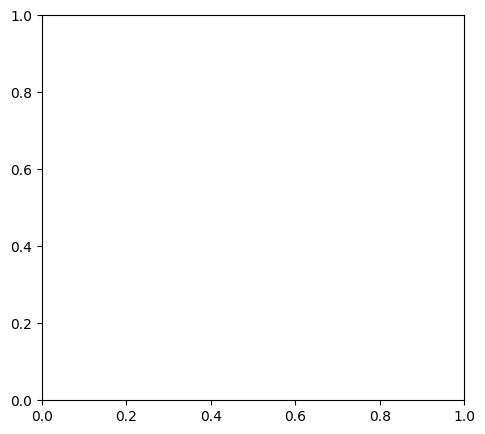

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1)
plt.legend()

plt.tight_layout()
plt.show()


# Load trained model from disk (optional)
Note: you need to run the cell that says "Define Model" still.

In [ ]:
# Check the device to either enable CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint
checkpoint_path = "/content/drive/MyDrive/Indicium/model_checkpoints/Jun_21_augmentations_finetuning/model_epoch_3.pth"  # or whichever checkpoint we want
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the model's state dictionary, weights, gradients and optimizer
model = OCT_net()
model.load_state_dict(checkpoint['model_state_dict'])

# put model to device
model.to(device)

for param in model.backbone.layer2.parameters():
    param.requires_grad = True

for param in model.backbone.layer3.parameters():
    param.requires_grad = True


for param in model.backbone.layer4.parameters():
    param.requires_grad = True


# Then, reinitialize the optimizer to include all parameters
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)


Get losses from the transfer learning model

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Specify the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define lists for plotting later
loaded_train_losses = []
loaded_val_losses = []
loaded_train_accuracies = []
loaded_val_accuracies = []

transfer_learning_epochs = 5  # Adjust based on checkpoints

for epoch in range(1, transfer_learning_epochs + 1):
    checkpoint_path = f"/content/drive/MyDrive/Indicium/model_checkpoints/Jun_21_augmentations_transferlearning/model_epoch_{epoch}.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Save the losses for plotting later
    epoch_train_losses = checkpoint.get('train_losses', [])
    epoch_val_losses = checkpoint.get('val_losses', [])
    epoch_train_accuracies = checkpoint.get('train_accuracies', [])
    epoch_val_accuracies = checkpoint.get('val_accuracies', [])

    loaded_train_losses.append(epoch_train_losses[epoch - 1])
    loaded_val_losses.append(epoch_val_losses[epoch - 1])
    loaded_train_accuracies.append(epoch_train_accuracies[epoch - 1])
    loaded_val_accuracies.append(epoch_val_accuracies[epoch - 1])

Get losses from the finetuned model

In [ ]:
fine_tuning_epochs = 10  # Adjust based on checkpoints

for epoch in range(1, fine_tuning_epochs + 1):
    checkpoint_path = f"/content/drive/MyDrive/Indicium/model_checkpoints/Jun_23_augmentations_finetuning/model_epoch_{epoch}.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Save the losses for plotting later
    epoch_train_losses = checkpoint.get('train_losses', [])
    epoch_val_losses = checkpoint.get('val_losses', [])
    epoch_train_accuracies = checkpoint.get('train_accuracies', [])
    epoch_val_accuracies = checkpoint.get('val_accuracies', [])

    loaded_train_losses.append(epoch_train_losses[epoch - 1])
    loaded_val_losses.append(epoch_val_losses[epoch - 1])
    loaded_train_accuracies.append(epoch_train_accuracies[epoch - 1])
    loaded_val_accuracies.append(epoch_val_accuracies[epoch - 1])

In [ ]:
epochs_to_plot = range(1, transfer_learning_epochs + fine_tuning_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_to_plot, loaded_train_losses, 'b-', label='Training Loss')
plt.plot(epochs_to_plot, loaded_val_losses, 'r-', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.3, 1)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_to_plot, loaded_train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs_to_plot, loaded_val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)
plt.legend()

plt.tight_layout()
plt.show()

# Inspect and run inference on an example:


---



In [ ]:
import torch.nn.functional as F
import random

# Define the biomarkers and label for indexing
label_map = {0: "DR", 1: "DME"}
biomarker_fields = [
    "Atrophy / thinning of retinal layers",
    "Disruption of EZ",
    "DRIL",
    "IR hemorrhages",
    "IR HRF",
    "Partially attached vitreous face",
    "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage",
    "Vitreous debris",
    "VMT",
    "DRT/ME",
    "Fluid (IRF)",
    "Fluid (SRF)",
    "Disruption of RPE",
    "PED (serous)",
    "SHRM"
]

# Directly access the dataset
dataset = test_dataloader.dataset

# Sample random index
random_idx = random.randint(0, len(dataset) - 1)

# Get a single example from dataset
example = dataset[random_idx]

# Get the image, biomarkers and labels. Use "unsqueeze" since the model expect a batch size of at least 1.
image = example['image pixel values'].unsqueeze(0).to(device)
true_biomarkers = example['biomarkers'].unsqueeze(0).to(device)
true_label = torch.tensor(example['label']).long().unsqueeze(0).to(device)

# Convert label if it's not a tensor
if not isinstance(example['label'], torch.Tensor):
    true_label = torch.tensor(example['label']).long().unsqueeze(0).to(device)
else:
    true_label = example['label'].long().unsqueeze(0).to(device)

# Set model to evaluation mode
model.eval()

# For inference, do not calculate gradients
with torch.no_grad():
  # Get the biomarker and disease label probabilities and the embedding
    biomarker_logits, disease_logits, learned_features = model(image, return_features=True)

# Apply sigmoid for the biomarkers since it is a multi-label classification task
biomarker_probs = torch.sigmoid(biomarker_logits).squeeze().cpu().numpy()
# Apply softmax for the disease labels, since it is a multi-class classification task
disease_probs = F.softmax(disease_logits, dim=1).squeeze().cpu().numpy()

# Get the predicted label and the true label
predicted_label = disease_probs.argmax()
true_label = true_label.item()

# Print out the formatted results
print(f"Random example index: {random_idx}")
print(f"True Disease Label: {label_map[true_label]}")
print(f"Predicted Disease Label: {label_map[predicted_label]}")
print("Disease Class Probabilities:")
for cls_idx, prob in enumerate(disease_probs):
    print(f"  {label_map[cls_idx]:<6}: {prob * 100:.2f}%")

print("\nBiomarker Probabilities:")
for name, prob, true_val in zip(biomarker_fields, biomarker_probs, true_biomarkers.squeeze().cpu().numpy()):
    print(f"{name:<35} | Predicted Probability: {prob:.3f} | True Value: {true_val:.3f}")


Random example index: 940
True Disease Label: DME
Predicted Disease Label: DR
Disease Class Probabilities:
  DR    : 52.23%
  DME   : 47.77%

Biomarker Probabilities:
Atrophy / thinning of retinal layers | Predicted Probability: 0.502 | True Value: 0.000
Disruption of EZ                    | Predicted Probability: 0.490 | True Value: 0.000
DRIL                                | Predicted Probability: 0.492 | True Value: 0.000
IR hemorrhages                      | Predicted Probability: 0.491 | True Value: 0.000
IR HRF                              | Predicted Probability: 0.475 | True Value: 1.000
Partially attached vitreous face    | Predicted Probability: 0.512 | True Value: 0.000
Fully attached vitreous face        | Predicted Probability: 0.500 | True Value: 1.000
Preretinal tissue/hemorrhage        | Predicted Probability: 0.509 | True Value: 0.000
Vitreous debris                     | Predicted Probability: 0.502 | True Value: 1.000
VMT                                 | Predicted P

# Embed to FAISS database (optional)


In [ ]:
from tqdm import tqdm

# Define lists to save to FAISS later
all_features = []
all_labels = []
all_biomarkers = []

# Here, we want to run inference and extract the learned features/embeddings.
with torch.no_grad():
  # Extract features from our test_dataloader dataset
    for batch in tqdm(train_dataloader, desc="Extracting features @ training"):
        images = batch['image pixel values'].to(device)
        labels = batch['label'].long().to(device)
        biomarkers = batch['biomarkers'].float().to(device)

        images = images.to(device)

        # Extract features just before disease head
        _, _, features = model(images, return_features=True)  # shape: [B, 256]
        features = features.cpu().numpy().astype("float32")   # FAISS expects float32

        all_features.append(features) # Features per sample
        all_labels.extend(labels.cpu().numpy()) # Labels per sample
        all_biomarkers.extend(biomarkers.cpu().numpy())  # Biomarkers per sample


Extracting features @ training: 100%|██████████| 446/446 [00:41<00:00, 10.79it/s]


In [ ]:
features_matrix = np.vstack(all_features)
labels_array = np.array(all_labels)
biomarkers_array = np.array(all_biomarkers)

print(features_matrix.shape)

(14247, 256)


In [ ]:
import faiss
import numpy as np
import os

def normalize_vectors(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

# Normalize your feature matrix
features_matrix = normalize_vectors(features_matrix)

d = features_matrix.shape[1]  # Feature size (2048)

# Build FAISS index with L2 distance
index = faiss.IndexFlatL2(d)
index.add(features_matrix)

save_date = "Jun_23"
save_dir = f"/content/drive/MyDrive/Indicium/FAISS_indexes/{save_date}_Jun23-model-finetuned"
os.makedirs(save_dir, exist_ok=True)

# Save index
faiss.write_index(index, f"{save_dir}/oct_features.index")

# Save labels (for ID mapping)
np.save(f"{save_dir}/oct_labels.npy", labels_array)
np.save(f"{save_dir}/oct_biomarkers.npy", biomarkers_array)


# Load FAISS index from disk and run inference

In [ ]:
labels_array = np.load(f"{save_dir}/oct_labels.npy")
biomarkers_array = np.load(f"{save_dir}/oct_biomarkers.npy")
index = faiss.read_index(f"{save_dir}/oct_features.index")

# Make a FAISS query

In [ ]:
label_map = {0: "DR", 1: "DME"}
biomarker_fields = [
    "Atrophy / thinning of retinal layers",
    "Disruption of EZ",
    "DRIL",
    "IR hemorrhages",
    "IR HRF",
    "Partially attached vitreous face",
    "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage",
    "Vitreous debris",
    "VMT",
    "DRT/ME",
    "Fluid (IRF)",
    "Fluid (SRF)",
    "Disruption of RPE",
    "PED (serous)",
    "SHRM"
]



# Query the image
def get_biomarkers_and_features(model, img):
    model.eval()
    with torch.no_grad():
        biomarkers, _, feat = model(img.to(device), return_features=True)
    return biomarkers.cpu(), feat.cpu().numpy().astype("float32")



# Directly access the dataset
sample_dataset = test_dataloader.dataset

# Sample random index
random_idx = random.randint(0, len(sample_dataset) - 1)
print(f"Random example index: {random_idx}")

# Get a single example from dataset
example = sample_dataset[random_idx]
query_img = example['image pixel values'].unsqueeze(0).to(device)
true_label = torch.tensor(example['label']).long().unsqueeze(0).to(device)


# Get query biomarkers and normalized features
query_biomarker_logits, query_feature = get_biomarkers_and_features(model, query_img)
query_biomarkers = torch.sigmoid(query_biomarker_logits).squeeze().cpu().numpy()
rounded_probs = np.round(query_biomarkers, 4).tolist()

# Search FAISS, use k=5
D, I = index.search(query_feature, k=5)
topk_labels = labels_array[I[0]]
topk_biomarkers = biomarkers_array[I[0]]
topk_distances = D[0]

# Pretty print results
print(f"\nQuery Results for True Label: {true_label.item()}\n")
print("[" + ", ".join(f"{x:.4f}" for x in rounded_probs) + "] \n")

for rank, (idx, dist, label, biomarkers) in enumerate(zip(I[0], topk_distances, topk_labels, topk_biomarkers), 1):
    print(f"Rank {rank}:")
    print(f"  Index:       {idx}")
    print(f"  Distance:    {dist:.4f}")
    print(f"  Label:       {label}")
    print(f"  Biomarkers:  {biomarkers}")
    print("-" * 40)



Random example index: 1130

Query Results for True Label: 1

[0.5096, 0.4903, 0.4885, 0.4733, 0.4887, 0.5045, 0.5041, 0.4905, 0.5095, 0.4744, 0.4992, 0.5151, 0.5005, 0.5243, 0.4894, 0.4963] 

Rank 1:
  Index:       10080
  Distance:    1.1553
  Label:       1
  Biomarkers:  [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
----------------------------------------
Rank 2:
  Index:       5251
  Distance:    1.1700
  Label:       0
  Biomarkers:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------
Rank 3:
  Index:       12032
  Distance:    1.1701
  Label:       0
  Biomarkers:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------
Rank 4:
  Index:       920
  Distance:    1.1775
  Label:       0
  Biomarkers:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----------------------------------------
Rank 5:
  Index:       10865
  Distance:    1.1824
  Label:       1
  Biomarkers:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0